In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math as m
import seaborn as sns

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Specify the path to your CSV file
# data_path = 'E:\\THESIS\\MS\\Data Collection - Preparation\\rg1-revised-cleaned-with-popcount-and-neighbors.csv'
data_path = '/content/drive/MyDrive/MS thesis/HFCAI/BARMM/barmm_cleaned_sum.csv'
df = pd.read_csv(data_path)
df.head(2)

,ID,bg_id,barangay_name,city_name,province_name,region_name,RHU_Presence,Road_Presence,POI_Presence,buildability_landcov,...,women_repr,womenmean,youthmean,all_popula,youth_children_sum,youth_elderly_sum,youth_phall_sum,youth_women_sum,youth_women_repr_sum,youth_youth_sum
0,2708537,bg-39207,Likud Bakkao,Turtle Islands,Tawi-Tawi,Autonomous Region In Muslim Mindanao (ARMM),0,0,0,NaN,...,3.033754,4.887959,2.387869,NaN,104.243678,51.920253,1248.510791,591.443039,367.084234,288.932149
1,2720913,bg-39123,Sikub,Mapun (Cagayan De Tawi-Tawi),Tawi-Tawi,Autonomous Region In Muslim Mindanao (ARMM),0,0,0,NaN,...,0.561532,1.040952,0.436198,0.793358,15.175698,9.350432,158.286798,77.030442,41.553380,32.278671


# HCFAI calculations

In [3]:
def HCI_calc(total_ai, total_gi, total_hi, total_ji, total_ki, total_mi,
              distance, road_bi, POI_ci, landCov_di, hazard1_ei, hazard2_ei, hazard3_ei, rhus_fi):

    total_vulnerable = total_gi + total_hi + total_ji + total_ki + total_mi
    total_pop = total_ai
    population_to_be_served = total_vulnerable + np.maximum(0, total_pop - total_vulnerable)

    # Calculate y for the entire Series without using if condition
    y = np.where(population_to_be_served == 0, 0, 20000 / ((population_to_be_served) * (distance + rhus_fi)))
    mc = np.tanh(y)

    w_bi = 0.3 # roads
    w_ci = 0.2 # POIs
    w_di = 0.5 # land cov

    b = (POI_ci * w_ci) + (road_bi * w_bi) + (landCov_di * w_di)

    # Normalize each factor
    rain_intensity_normalized = (hazard1_ei - hazard1_ei.min()) / (hazard1_ei.max() - hazard1_ei.min())
    flood_probability_normalized = (hazard2_ei - hazard2_ei.min()) / (hazard2_ei.max() - hazard2_ei.min())
    drought_mean_normalized = (hazard3_ei - hazard3_ei.min()) / (hazard3_ei.max() - hazard3_ei.min())
    w_rain = 0.4
    w_flood = 0.3
    w_drought = 0.3
    c = (w_rain * rain_intensity_normalized) + (w_flood * flood_probability_normalized) + (w_drought * drought_mean_normalized)

    f = b - c
    f = np.tanh(f)

    hci = mc * f
    hcfai = (1 + np.tanh(hci / 2)) / 2  # Sigmoid function

    return hcfai

In [4]:
df.columns

Index(['ID', 'bg_id', 'barangay_name', 'city_name', 'province_name',
       'region_name', 'RHU_Presence', 'Road_Presence', 'POI_Presence',
       'buildability_landcov', 'Nearest_RHU', 'Distance_to_Nearest_RHU_km',
       'drought_value', 'flood_probability_value', 'rain intensity_value',
       'children_u', 'elderly_60', 'women_repr', 'womenmean', 'youthmean',
       'all_popula', 'youth_children_sum', 'youth_elderly_sum',
       'youth_phall_sum', 'youth_women_sum', 'youth_women_repr_sum',
       'youth_youth_sum'],
      dtype='object')

In [5]:
df.columns
# Rename columns
column_mapping = {
    'youth_youth_sum': 'popden_you',
    'youth_women_sum': 'popden_wom',
    'youth_women_repr_sum': 'popden_w_1',
    'youth_elderly_sum': 'popden_eld',
    'youth_children_sum': 'popden_chi',
    'youth_phall_sum': 'popden_all',
}

dropcols = ['children_u', 'elderly_60', 'women_repr', 'womenmean', 'youthmean',
       'all_popula']
df = df.drop(columns=dropcols)

df = df.rename(columns=column_mapping)
df.loc[df['RHU_Presence'] == 1, 'Distance_to_Nearest_RHU_km'] = 0
df[df['RHU_Presence'] == 1]

,ID,bg_id,barangay_name,city_name,province_name,region_name,RHU_Presence,Road_Presence,POI_Presence,buildability_landcov,...,Distance_to_Nearest_RHU_km,drought_value,flood_probability_value,rain intensity_value,popden_chi,popden_eld,popden_all,popden_wom,popden_w_1,popden_you
222,2899307,bg-39211,Darussalam,Languyan,Tawi-Tawi,Autonomous Region In Muslim Mindanao (ARMM),1,0,0,0.0,...,0.0,0.782888,0.806954,0.649332,8.926904,5.089868,101.093594,52.856825,25.606182,19.419967
302,2976681,bg-38925,Tong-tong,Siasi,Sulu,Autonomous Region In Muslim Mindanao (ARMM),1,0,1,0.0,...,0.0,0.716486,0.757822,0.645443,373.285683,118.473794,5378.912051,2759.317922,1487.237795,1187.434994
310,2979444,bg-38885,Poblacion (Campo Baro),Siasi,Sulu,Autonomous Region In Muslim Mindanao (ARMM),1,0,0,0.0,...,0.0,0.740278,0.666753,0.645262,75.333382,58.821956,1050.539478,526.301704,319.908878,217.744430
396,2998767,bg-38739,Poblacion (Maimbung),Maimbung,Sulu,Autonomous Region In Muslim Mindanao (ARMM),1,0,1,0.0,...,0.0,0.881611,0.739322,0.621261,193.960791,22.557196,1288.863535,647.614610,331.691152,229.152180
423,3113434,bg-36954,Bohe-Pahuh,Ungkaya Pukan,Basilan,Autonomous Region In Muslim Mindanao (ARMM),1,0,0,1.0,...,0.0,0.793008,0.301379,0.673888,4.977059,1.079469,35.368527,17.335205,8.534881,6.007863
427,3114806,bg-36812,Boheyawas,City of Lamitan,Basilan,Autonomous Region In Muslim Mindanao (ARMM),1,0,1,1.0,...,0.0,0.849306,0.840884,0.693443,10.275387,5.527626,80.094939,39.328929,19.533636,15.249879
429,3114817,bg-36893,Sapah Bulak,Sumisip,Basilan,Autonomous Region In Muslim Mindanao (ARMM),1,0,1,0.0,...,0.0,0.754519,0.293768,0.674711,21.873480,3.274440,138.968520,72.627840,31.107480,21.677040
445,3118953,bg-36815,Maganda,City of Lamitan,Basilan,Autonomous Region In Muslim Mindanao (ARMM),1,0,1,0.0,...,0.0,0.840049,0.850477,0.701609,370.629559,158.744645,3116.485674,1565.199510,798.523234,593.763643
448,3118964,bg-36902,Baguindan,Tipo-Tipo,Basilan,Autonomous Region In Muslim Mindanao (ARMM),1,0,1,0.0,...,0.0,0.708655,0.273977,0.682473,76.596668,12.292055,533.909507,276.871468,142.687942,118.232454
483,3324791,bg-37220,Pindolonan,Ganassi,Lanao del Sur,Autonomous Region In Muslim Mindanao (ARMM),1,0,0,0.0,...,0.0,0.567100,0.110306,0.966702,61.185373,8.547444,432.807492,232.133014,116.114076,91.994520


In [6]:
# Get column names with NaNs using list comprehension
columns_with_nan = [col for col in df.columns if df[col].isna().any()]

# Print the column names
print("Columns with NaN values:", columns_with_nan)

Columns with NaN values: ['buildability_landcov', 'rain intensity_value']


In [7]:
# Impute NaNs with 0, considering data type safety
for col in columns_with_nan:
    # Check data type before imputing (avoid unintended conversions)
    if pd.api.types.is_numeric_dtype(df[col]):
        df[col] = df[col].fillna(0)  # Impute with 0 for numeric columns
    else:
        df[col] = df[col].fillna('NA')  # Impute with 'NA' for non-numeric columns
df

,ID,bg_id,barangay_name,city_name,province_name,region_name,RHU_Presence,Road_Presence,POI_Presence,buildability_landcov,...,Distance_to_Nearest_RHU_km,drought_value,flood_probability_value,rain intensity_value,popden_chi,popden_eld,popden_all,popden_wom,popden_w_1,popden_you
0,2708537,bg-39207,Likud Bakkao,Turtle Islands,Tawi-Tawi,Autonomous Region In Muslim Mindanao (ARMM),0,0,0,0.0,...,216.535563,0.587594,0.003302,0.819815,104.243678,51.920253,1248.510791,591.443039,367.084234,288.932149
1,2720913,bg-39123,Sikub,Mapun (Cagayan De Tawi-Tawi),Tawi-Tawi,Autonomous Region In Muslim Mindanao (ARMM),0,0,0,0.0,...,248.670612,0.542750,0.636563,0.759982,15.175698,9.350432,158.286798,77.030442,41.553380,32.278671
2,2720914,bg-39127,Erok-erok,Mapun (Cagayan De Tawi-Tawi),Tawi-Tawi,Autonomous Region In Muslim Mindanao (ARMM),0,0,0,0.0,...,248.107823,0.542142,0.637052,0.760291,41.641680,13.325326,225.790578,114.746040,52.005874,28.686510
3,2722294,bg-39118,Kompang,Mapun (Cagayan De Tawi-Tawi),Tawi-Tawi,Autonomous Region In Muslim Mindanao (ARMM),0,0,0,0.0,...,247.858424,0.539215,0.534102,0.757254,15.274236,13.876177,234.821835,112.514904,64.277047,54.170847
4,2722295,bg-39127,Erok-erok,Mapun (Cagayan De Tawi-Tawi),Tawi-Tawi,Autonomous Region In Muslim Mindanao (ARMM),0,0,0,0.0,...,247.352915,0.542142,0.637052,0.760291,45.674227,15.243871,253.780666,128.619432,58.794588,33.657194
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
747,3410548,bg-38183,Mangadeg,Datu Paglas,Maguindanao,Autonomous Region In Muslim Mindanao (ARMM),0,1,1,0.0,...,1.646340,1.307077,0.376025,0.737530,30.284709,3.979050,203.250177,98.452593,48.810816,38.876259
748,3411930,bg-38181,Katil,Datu Paglas,Maguindanao,Autonomous Region In Muslim Mindanao (ARMM),1,1,0,0.0,...,0.000000,1.301960,0.374058,0.739402,37.031753,2.322891,164.729402,77.112762,38.189604,28.051106
749,3411931,bg-38185,Puya,Datu Paglas,Maguindanao,Autonomous Region In Muslim Mindanao (ARMM),0,0,0,0.0,...,1.646419,1.285973,0.385058,0.734010,28.308372,2.127528,162.692222,80.355348,38.575920,30.584196
750,3413311,bg-38181,Katil,Datu Paglas,Maguindanao,Autonomous Region In Muslim Mindanao (ARMM),0,0,0,0.0,...,1.646315,1.301960,0.374058,0.739402,6.946916,0.917463,63.715808,29.042843,16.319852,15.512167


In [8]:
columns_with_nan = [col for col in df.columns if df[col].isna().any()]
print("Columns with NaN values:", columns_with_nan)

Columns with NaN values: []


In [9]:
# VARIABLES
# population vulnerable
popall = df["popden_all"]
children = df["popden_chi"]
elderly = df["popden_eld"]
women = df["popden_wom"]
women_reproductive = df["popden_w_1"]
youth = df["popden_you"]
distance = df["Distance_to_Nearest_RHU_km"]

flood = df["flood_probability_value"]
rain_intensity = df["rain intensity_value"]
drought = df["drought_value"]
roads = df["Road_Presence"]
rhus = df["RHU_Presence"]
pois = df["POI_Presence"]
buildability = df["buildability_landcov"]

In [10]:
df['HCFAI'] = HCI_calc(popall, children, elderly, women, women_reproductive, youth, distance,
    roads, pois, buildability, drought, rain_intensity, flood, rhus)

# Data exploration and visualization

In [11]:
nan_rows = df[df['HCFAI'].isna()]
nan_rows
df = df.dropna(subset=['HCFAI'])
df

,ID,bg_id,barangay_name,city_name,province_name,region_name,RHU_Presence,Road_Presence,POI_Presence,buildability_landcov,...,drought_value,flood_probability_value,rain intensity_value,popden_chi,popden_eld,popden_all,popden_wom,popden_w_1,popden_you,HCFAI
0,2708537,bg-39207,Likud Bakkao,Turtle Islands,Tawi-Tawi,Autonomous Region In Muslim Mindanao (ARMM),0,0,0,0.0,...,0.587594,0.003302,0.819815,104.243678,51.920253,1248.510791,591.443039,367.084234,288.932149,0.496095
1,2720913,bg-39123,Sikub,Mapun (Cagayan De Tawi-Tawi),Tawi-Tawi,Autonomous Region In Muslim Mindanao (ARMM),0,0,0,0.0,...,0.542750,0.636563,0.759982,15.175698,9.350432,158.286798,77.030442,41.553380,32.278671,0.458316
2,2720914,bg-39127,Erok-erok,Mapun (Cagayan De Tawi-Tawi),Tawi-Tawi,Autonomous Region In Muslim Mindanao (ARMM),0,0,0,0.0,...,0.542142,0.637052,0.760291,41.641680,13.325326,225.790578,114.746040,52.005874,28.686510,0.469721
3,2722294,bg-39118,Kompang,Mapun (Cagayan De Tawi-Tawi),Tawi-Tawi,Autonomous Region In Muslim Mindanao (ARMM),0,0,0,0.0,...,0.539215,0.534102,0.757254,15.274236,13.876177,234.821835,112.514904,64.277047,54.170847,0.473013
4,2722295,bg-39127,Erok-erok,Mapun (Cagayan De Tawi-Tawi),Tawi-Tawi,Autonomous Region In Muslim Mindanao (ARMM),0,0,0,0.0,...,0.542142,0.637052,0.760291,45.674227,15.243871,253.780666,128.619432,58.794588,33.657194,0.472839
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
747,3410548,bg-38183,Mangadeg,Datu Paglas,Maguindanao,Autonomous Region In Muslim Mindanao (ARMM),0,1,1,0.0,...,1.307077,0.376025,0.737530,30.284709,3.979050,203.250177,98.452593,48.810816,38.876259,0.462566
748,3411930,bg-38181,Katil,Datu Paglas,Maguindanao,Autonomous Region In Muslim Mindanao (ARMM),1,1,0,0.0,...,1.301960,0.374058,0.739402,37.031753,2.322891,164.729402,77.112762,38.189604,28.051106,0.416949
749,3411931,bg-38185,Puya,Datu Paglas,Maguindanao,Autonomous Region In Muslim Mindanao (ARMM),0,0,0,0.0,...,1.285973,0.385058,0.734010,28.308372,2.127528,162.692222,80.355348,38.575920,30.584196,0.361776
750,3413311,bg-38181,Katil,Datu Paglas,Maguindanao,Autonomous Region In Muslim Mindanao (ARMM),0,0,0,0.0,...,1.301960,0.374058,0.739402,6.946916,0.917463,63.715808,29.042843,16.319852,15.512167,0.361038


In [12]:
print(max(list(df['HCFAI'].unique())))
# list(df['HCFAI'].unique())
print(min(list(df['HCFAI'].unique())))
# list(df['drought_value'])
# list(df['rain intensity_value'])
# list(df['flood_probability_value'])
for col in df.columns:
  print(col)

0.6354666569046445
0.34985193673407244
ID
bg_id
barangay_name
city_name
province_name
region_name
RHU_Presence
Road_Presence
POI_Presence
buildability_landcov
Nearest_RHU
Distance_to_Nearest_RHU_km
drought_value
flood_probability_value
rain intensity_value
popden_chi
popden_eld
popden_all
popden_wom
popden_w_1
popden_you
HCFAI


Dropped Rows that had HCFAI = nan

In [13]:
# mid_to_high = []
# for i in list(df['HCFAI']):
#     if i >= 0.53:
#         mid_to_high.append(i)

# filtered_original_df = df[df['HCFAI'].isin(mid_to_high)]
# filtered_original_df = df[df['RHU_Presence'] == 1]

# x = df['HCFAI'].notna() # removing nan values
# x = df[x]
x=df[['popden_all', 'popden_you', "popden_w_1",
                      "popden_wom", "popden_eld", 'popden_chi',
                      'Distance_to_Nearest_RHU_km', "POI_Presence", "Road_Presence", "RHU_Presence",
                      'buildability_landcov', "drought_value", "rain intensity_value",
                         "flood_probability_value", "HCFAI"]]
x = x.sort_values(by='HCFAI', ascending=False)
# x[x['RHU_Presence']==0] # 4674 rows
x # 4701 rows
# len(locs_with_RHU['RHU_Presence'])

,popden_all,popden_you,popden_w_1,popden_wom,popden_eld,popden_chi,Distance_to_Nearest_RHU_km,POI_Presence,Road_Presence,RHU_Presence,buildability_landcov,drought_value,rain intensity_value,flood_probability_value,HCFAI
539,519.792572,96.784840,128.364228,263.343179,5.548628,79.079498,8.237737,1,1,0,1.0,0.639380,1.106916,0.112316,0.635467
487,141.583224,25.708059,32.767754,70.154279,5.121439,26.127884,1.647829,1,1,0,1.0,0.727157,0.975271,0.109398,0.634995
567,70.598736,14.571216,17.034048,34.067952,1.847088,11.287584,1.647527,1,1,0,1.0,0.738833,0.959977,0.118986,0.634317
686,117.661905,15.688260,23.980635,60.063615,0.448245,13.671180,0.000000,1,1,1,1.0,0.797618,1.006261,0.154539,0.626222
528,154.686240,35.980120,34.846920,68.843880,17.848400,14.448720,7.504187,0,1,0,1.0,0.647501,1.113930,0.088207,0.599855
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
684,119.644236,19.729116,28.030914,63.582354,0.879012,15.724692,1.647331,0,0,0,0.0,1.350125,0.771746,0.434999,0.353724
692,152.677952,33.917800,37.794550,72.442352,4.359768,14.023292,5.706339,0,0,0,0.0,1.343102,0.754531,0.459339,0.353665
731,3.983948,0.897592,1.107124,1.996224,0.223692,0.291648,0.000000,0,0,1,0.0,1.439156,0.767406,0.403463,0.349852
722,50.795337,11.444298,14.115831,25.451856,2.852073,3.718512,2.378597,0,0,0,0.0,1.439156,0.767406,0.403463,0.349852


In [14]:
locs_with_RHU = x[x['RHU_Presence']==1] # 37 rows (bcos there are nan values we disregarded from the original 42 that were correctly geocoded)
len(locs_with_RHU)

37

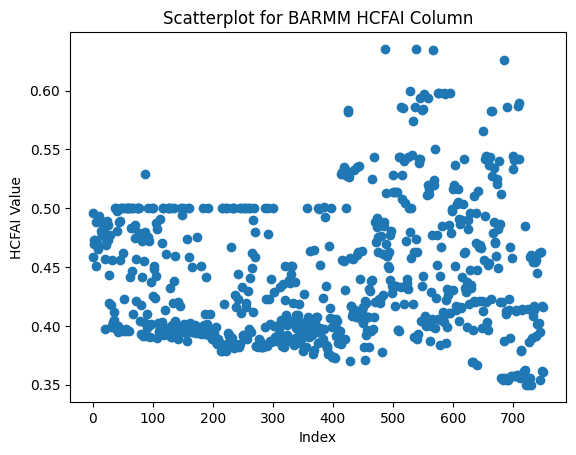

In [15]:
# Scatterplot for the 'HCFAI' column
plt.scatter(x.index, x['HCFAI'])
plt.title('Scatterplot for BARMM HCFAI Column')
plt.xlabel('Index')
plt.ylabel('HCFAI Value')
plt.show()

# Feasibility Factors

In [ ]:
# a = a['buildability_landcov'].notna()
a = df[['Road_Presence', 'POI_Presence', 'RHU_Presence', 'buildability_landcov',
       'drought_value', 'rain intensity_value', 'flood_probability_value', 'HCFAI']]

a = a[a['RHU_Presence']==0]
a = a.sort_values(by='HCFAI', ascending=False)
a

,Road_Presence,POI_Presence,RHU_Presence,buildability_landcov,drought_value,rain intensity_value,flood_probability_value,HCFAI
487,1,1,0,1.0,0.727157,0.975271,0.109398,0.643070
567,1,1,0,1.0,0.738833,0.959977,0.118986,0.643035
539,1,1,0,1.0,0.639380,1.106916,0.112316,0.638336
711,1,1,0,1.0,1.220922,0.703075,0.407485,0.614875
709,1,1,0,1.0,1.260414,0.717643,0.397918,0.610863
...,...,...,...,...,...,...,...,...
691,0,0,0,0.0,1.335032,0.747611,0.464469,0.371705
692,0,0,0,0.0,1.343102,0.754531,0.459339,0.370796
684,0,0,0,0.0,1.350125,0.771746,0.434999,0.370114
722,0,0,0,0.0,1.439156,0.767406,0.403463,0.365840


# Maximal Coverage Factors

In [ ]:
b = df[['popden_you', 'popden_wom', 'popden_eld', 'popden_chi',
       'popden_w_1', 'popden_all', 'Distance_to_Nearest_RHU_km', 'RHU_Presence', 'HCFAI']]
# b = b[b['buildability_landcov']==1]
b = b.sort_values(by='HCFAI', ascending=False)
# b[b['RHU_Presence']==1]
b

,popden_you,popden_wom,popden_eld,popden_chi,popden_w_1,popden_all,Distance_to_Nearest_RHU_km,RHU_Presence,HCFAI
487,0.829292,2.263041,0.165208,0.842835,1.057024,0.927838,1.647829,0,0.643070
567,0.101189,0.236583,0.012827,0.078386,0.118292,0.073577,1.647527,0,0.643035
539,0.393434,1.070501,0.022555,0.321461,0.521806,5.161076,8.237737,0,0.638336
686,0.348628,1.334747,0.009961,0.303804,0.532903,0.360849,0.000000,1,0.633567
711,0.626903,1.618176,0.088818,0.459450,0.766313,1.976015,6.588973,0,0.614875
...,...,...,...,...,...,...,...,...,...
692,0.847945,1.811059,0.108994,0.350582,0.944864,0.440413,5.706339,0,0.370796
684,0.365354,1.177451,0.016278,0.291198,0.519091,0.693144,1.647331,0,0.370114
731,0.224398,0.499056,0.055923,0.072912,0.276781,0.233144,0.000000,1,0.365840
726,0.224398,0.499056,0.055923,0.072912,0.276781,0.394396,0.981406,0,0.365840


# EDA

In [ ]:
c=df['HCFAI'].notna()
c = df[c]
# c = df[['population_youth', 'population_women', 'population_elder60plus', 'population_children_under5',
#        'population_reproductive_women', 'popden_all_total_population', 'Distance_to_Nearest_RHU_km',
#         'Road_Presence', 'POI_Presence', 'RHU_Presence', 'buildability_landcov', 'drought_value', 'rain intensity_value',
#         'flood_probability_value', 'HCFAI']]
# c = c[c['RHU_Presence']==1]
c = c.sort_values(by='HCFAI', ascending=False)
c = c[['population_youth', 'population_women', 'population_elder60plus', 'population_children_under5',
       'population_reproductive_women', 'popden_all_total_population', 'Distance_to_Nearest_RHU_km',
        'Road_Presence', 'POI_Presence', 'RHU_Presence', 'buildability_landcov', 'drought_value', 'rain intensity_value',
        'flood_probability_value', 'HCFAI']]
c.sort_values(by='HCFAI', ascending=False)

,population_youth,population_women,population_elder60plus,population_children_under5,population_reproductive_women,popden_all_total_population,Distance_to_Nearest_RHU_km,Road_Presence,POI_Presence,RHU_Presence,buildability_landcov,drought_value,rain intensity_value,flood_probability_value,HCFAI
5703,0.000000,0.000000,0.0,0.000000,0.000000,376.429135,18.697599,1,0,0,1.0,0.542848,2.371210,0.962631,0.581876
1099,0.000000,0.000000,0.0,0.000000,0.000000,466.445625,24.862448,0,0,0,1.0,0.672856,0.268539,0.305392,0.563102
4334,0.000000,0.000000,0.0,0.000000,0.000000,1139.223628,29.861002,0,0,0,1.0,0.713175,0.153043,0.229447,0.534900
2704,0.000000,0.000000,0.0,0.000000,0.000000,23.816927,10.621421,0,0,0,1.0,0.834131,0.092033,0.815355,0.521743
3490,0.000000,0.000000,0.0,0.000000,0.000000,693.544396,13.991199,0,0,0,1.0,0.884191,0.099185,0.681102,0.516955
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3900,11520.305136,21600.533088,0.0,2880.050256,12960.330264,50247.186329,2.858075,0,0,0,0.0,0.783897,2.857803,0.389312,0.481524
3937,0.000000,0.000000,0.0,0.000000,0.000000,2736.210123,11.314957,0,0,0,1.0,0.795406,1.766906,1.284616,0.480502
944,0.000000,0.000000,0.0,0.000000,0.000000,5875.884038,10.289214,0,0,0,0.0,0.686629,0.277878,0.934151,0.473992
5,0.000000,0.000000,0.0,0.000000,0.000000,4021.250203,16.685262,0,0,0,0.0,0.800627,1.151205,0.700863,0.467737


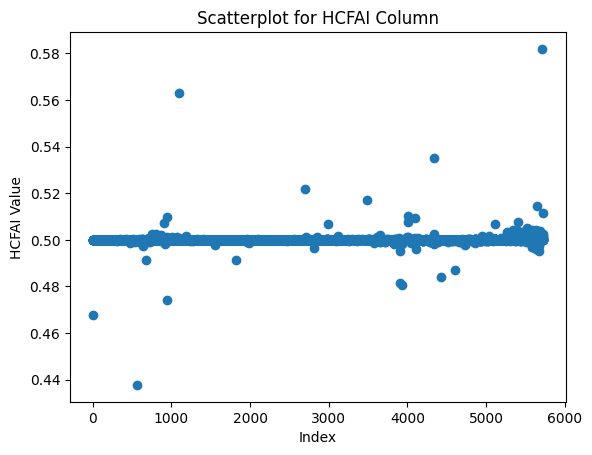

In [ ]:
# Scatterplot for the 'HCFAI' column
plt.scatter(c.index, c['HCFAI'])
plt.title('Scatterplot for HCFAI Column')
plt.xlabel('Index')
plt.ylabel('HCFAI Value')
plt.show()

# Exporting

In [16]:
# Specify the file path for the CSV file
csv_file_path = '/content/drive/MyDrive/MS thesis/HFCAI/BARMM/barmm_HCFAI_sum.csv'
# Export the DataFrame to a CSV file
df.to_csv(csv_file_path, index=False)
print(f'DataFrame exported to CSV file: {csv_file_path}')

DataFrame exported to CSV file: /content/drive/MyDrive/MS thesis/HFCAI/BARMM/barmm_HCFAI_sum.csv
